In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_3.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["totalTimeSeconds"] = dataFrame["totalTimeSeconds"].astype(float)
dataFrame["avgRoundTripSeconds"] = dataFrame["avgRoundTripSeconds"].astype(float)
dataFrame["bandwidthBytesPerSec"] = dataFrame["bandwidthBytesPerSec"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 50
Message sizes: [1, 8, 64, 512, 4096, 32768, 262144, 1048576, 4194304, 8388608]
Process counts: [2]


,testType,messageSizeBytes,numProcesses,numIterations,totalTimeSeconds,avgRoundTripSeconds,bandwidthBytesPerSec,runIndex,mpiEnv
0,MPI_3,1,2,20000,0.006032,3.020000e-07,6.630970e+06,1,PROCS=2
1,MPI_3,1,2,20000,0.007183,3.590000e-07,5.568394e+06,2,PROCS=2
2,MPI_3,1,2,20000,0.006718,3.360000e-07,5.953798e+06,3,PROCS=2
3,MPI_3,1,2,20000,0.006343,3.170000e-07,6.306065e+06,4,PROCS=2
4,MPI_3,1,2,20000,0.006012,3.010000e-07,6.653028e+06,5,PROCS=2
5,MPI_3,8,2,20000,0.005806,2.900000e-07,5.511825e+07,1,PROCS=2
6,MPI_3,8,2,20000,0.006139,3.070000e-07,5.212660e+07,2,PROCS=2
7,MPI_3,8,2,20000,0.006047,3.020000e-07,5.292230e+07,3,PROCS=2


In [4]:
groupedFrame = dataFrame.groupby(["messageSizeBytes"], as_index=False).agg(
    medianRTT=("avgRoundTripSeconds","median"),
    meanRTT=("avgRoundTripSeconds","mean"),
    stdRTT=("avgRoundTripSeconds","std"),
    medianThroughput=("bandwidthBytesPerSec","median"),
    meanThroughput=("bandwidthBytesPerSec","mean"),
    stdThroughput=("bandwidthBytesPerSec","std"),
    count=("avgRoundTripSeconds","count")
)
groupedFrame["stdRTT"] = groupedFrame["stdRTT"].fillna(0.0)
groupedFrame["stdThroughput"] = groupedFrame["stdThroughput"].fillna(0.0)
groupedFrame = groupedFrame.sort_values("messageSizeBytes").reset_index(drop=True)
groupedFrame


,messageSizeBytes,medianRTT,meanRTT,stdRTT,medianThroughput,meanThroughput,stdThroughput,count
0,1,3.170000e-07,3.230000e-07,2.462722e-08,6.306065e+06,6.222451e+06,4.634761e+05,5
1,8,3.020000e-07,2.990000e-07,9.974969e-09,5.292230e+07,5.353712e+07,1.751615e+06,5
2,64,3.300000e-07,3.264000e-07,1.211610e-08,3.876321e+08,3.925091e+08,1.486134e+07,5
3,512,4.410000e-07,4.430000e-07,1.428286e-08,2.322838e+09,2.313808e+09,7.390992e+07,5
4,4096,3.332000e-06,3.307600e-06,4.292785e-08,2.458547e+09,2.477035e+09,3.237885e+07,5
5,32768,4.321000e-06,4.359800e-06,2.736251e-07,1.516739e+10,1.507853e+10,9.397256e+08,5
6,262144,1.978600e-05,1.985300e-05,8.097385e-07,2.649820e+10,2.644258e+10,1.046771e+09,5
7,1048576,7.882600e-05,7.878820e-05,1.310002e-06,2.660483e+10,2.662337e+10,4.420249e+08,5
8,4194304,3.253940e-04,3.254948e-04,1.337198e-05,2.577985e+10,2.580670e+10,1.060170e+09,5
9,8388608,1.062424e-03,1.085175e-03,4.885395e-05,1.579145e+10,1.548417e+10,6.606888e+08,5


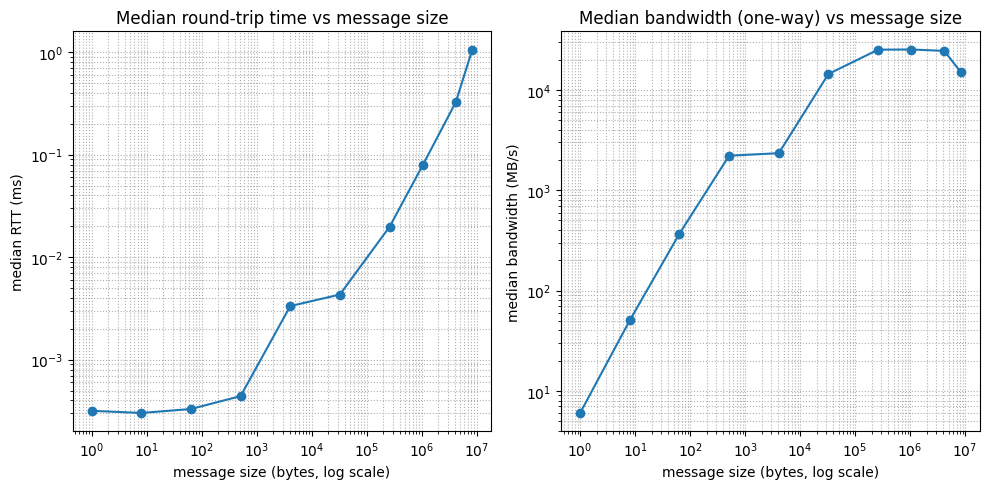

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x = groupedFrame["messageSizeBytes"]
y = groupedFrame["medianRTT"] * 1e3  # ms
plt.loglog(x, y, marker='o', linestyle='-')
plt.xlabel("message size (bytes, log scale)")
plt.ylabel("median RTT (ms)")
plt.title("Median round-trip time vs message size")
plt.grid(True, which="both", ls=":")

plt.subplot(1,2,2)
x = groupedFrame["messageSizeBytes"]
y = groupedFrame["medianThroughput"] / (1024.0*1024.0)  # MB/s
plt.loglog(x, y, marker='o', linestyle='-')
plt.xlabel("message size (bytes, log scale)")
plt.ylabel("median bandwidth (MB/s)")
plt.title("Median bandwidth (one-way) vs message size")
plt.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()


In [ ]:
display(groupedFrame.assign(
    medianRTTms = groupedFrame["medianRTT"]*1e3,
    medianThroughputMBs = groupedFrame["medianThroughput"]/(1024*1024)
))


,messageSizeBytes,medianRTT,meanRTT,stdRTT,medianThroughput,meanThroughput,stdThroughput,count,medianRTTms,medianThroughputMBs
0,1,3.170000e-07,3.230000e-07,2.462722e-08,6.306065e+06,6.222451e+06,4.634761e+05,5,0.000317,6.013932
1,8,3.020000e-07,2.990000e-07,9.974969e-09,5.292230e+07,5.353712e+07,1.751615e+06,5,0.000302,50.470642
2,64,3.300000e-07,3.264000e-07,1.211610e-08,3.876321e+08,3.925091e+08,1.486134e+07,5,0.000330,369.674790
3,512,4.410000e-07,4.430000e-07,1.428286e-08,2.322838e+09,2.313808e+09,7.390992e+07,5,0.000441,2215.231129
4,4096,3.332000e-06,3.307600e-06,4.292785e-08,2.458547e+09,2.477035e+09,3.237885e+07,5,0.003332,2344.652696
5,32768,4.321000e-06,4.359800e-06,2.736251e-07,1.516739e+10,1.507853e+10,9.397256e+08,5,0.004321,14464.746474
6,262144,1.978600e-05,1.985300e-05,8.097385e-07,2.649820e+10,2.644258e+10,1.046771e+09,5,0.019786,25270.648625
7,1048576,7.882600e-05,7.878820e-05,1.310002e-06,2.660483e+10,2.662337e+10,4.420249e+08,5,0.078826,25372.339044
8,4194304,3.253940e-04,3.254948e-04,1.337198e-05,2.577985e+10,2.580670e+10,1.060170e+09,5,0.325394,24585.579299
9,8388608,1.062424e-03,1.085175e-03,4.885395e-05,1.579145e+10,1.548417e+10,6.606888e+08,5,1.062424,15059.900737
